In [1]:
using Lux, Optimisers, Random, ForwardDiff, Statistics, LinearAlgebra, Plots, PlotThemes; theme(:dao)
const FD = ForwardDiff;

In [2]:
rng = Random.MersenneTwister();

In [107]:
nNeurons = 40;
ψmodel = Chain(
    Dense(2 => nNeurons, tanh), #input [x,t]
    Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => nNeurons, tanh),
    # Dense(nNeurons => nNeurons, tanh),
    # Dense(nNeurons => nNeurons, tanh),
    # Dense(nNeurons => nNeurons, tanh),
    Dense(nNeurons => 2, identity), #output [re(ψ), im(ψ)]
)

Chain(
    layer_1 = Dense(2 => 40, tanh_fast),  # 120 parameters
    layer_2 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_3 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_4 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_5 = Dense(40 => 40, tanh_fast),  # 1_640 parameters
    layer_6 = Dense(40 => 2),           # 82 parameters
)         # Total: 6_762 parameters,
          #        plus 0 states, summarysize 96 bytes.

In [108]:
ps, st = Lux.setup(rng, ψmodel);

In [29]:
xtest = randn(2);
y, st = Lux.apply(ψmodel, xtest, ps, st)

([-0.5463319434658296, -0.009438995703147546], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [30]:
function vector_hessian(f, x)
    n = length(x)
    out = ForwardDiff.jacobian(x -> ForwardDiff.jacobian(f, x), x)
    return reshape(out, n, n, n)
end

vector_hessian (generic function with 1 method)

In [31]:
# ψNN(x,t) = [x^2 + t, t+exp(x)]

Let $E$ be some units of energy. The dimension-less Schrodinger equation is:
$$
i \frac{\partial \psi}{\partial \tau} = -\frac{1}{2} \frac{\partial^2\psi}{\partial \xi^2} + (V(\beta\xi)/E)\psi
\\
\beta = \frac{\hbar}{\sqrt{m E}}
\\
x = \beta \xi
\\
t = \frac{\hbar}{E} \tau
$$

In [32]:
# ForwardDiff.derivative(x -> ψNN(x,1.0),1.0)

In [33]:
# ψNN(x,t) = (Lux.apply(ψmodel, [x,t], ps, st)[1])
# ∂ψ∂t(ψ,x,t) = FD.derivative(t -> ψ(x,t),t) |> X -> complex(X...);
# ∂²ψ∂x²(ψ,x,t) = FD.derivative(x->FD.derivative(x->ψ(x,t),x),x) |> X -> complex(X...);
# V(x) = 0;
# TDSE(ψ,x,t) = 1.0im*∂ψ∂t(ψ,x,t) - (-∂²ψ∂x²(ψ,x,t)/2 + V(x)*complex(ψ(x,t)...));

In [109]:
Ncollocation = 2000;
Tmax = 50.0;
collocationPts =(hcat(rand(Ncollocation), Tmax*rand(Ncollocation)))';
# collocationPts =(collect∘eachrow)(hcat(rand(Ncollocation), Tmax*rand(Ncollocation)));
N∂t₀ = 200;
N∂x = 200;
ψ₀(x) = (collect∘reim)( sin(π*x) + sin(2π*x));
∂xt0 = hcat(rand(N∂t₀),zeros(N∂t₀));
ψ₀∂xt0 = collect(hcat(ψ₀.(∂xt0[:,1])...)');
∂x0t = vcat(hcat(zeros(N∂x),Tmax*rand(N∂x)),hcat(ones(N∂x),Tmax*rand(N∂x)));
ψ∂x0t = zeros(size(∂x0t));
∂xt = (collect∘eachrow)(vcat(∂xt0,∂x0t));
∂ψxt = (collect∘eachrow)(vcat(ψ₀∂xt0,ψ∂x0t));

In [35]:
using Zygote


In [36]:
Zygote.forward_jacobian(X->Lux.apply(ψmodel, X, ps, st)[1],collocationPts)

([-0.9386943331096035 -0.9711432182205229 … -0.9729987954261998 -0.9821710537221409; -0.019634630174917136 -0.1294542742379175 … -0.08819264830132056 -0.1559961930031844], [-0.04267869484772131 -0.05592463562306113 … 0.0 0.0; 0.00027890076461791315 -0.004437645901432934 … 0.0 0.0; … ; 0.0 0.0 … -0.01658967713111277 -0.03733407148504703; 0.0 0.0 … -0.0008229254293490153 -0.0021216527518573883])

In [110]:
∂ψ∂t(ψ,x,t) = FD.derivative(t -> ψ(x,t),t) |> X -> complex(X...);
# ∂²ψ∂x²(ψ,x,t) = jacobian(x->ψ(x,t),x)# |> X -> complex(X...)
#jacobian(x->jacobian(x->ψ(x,t),x)[1],x)[1]# |> X -> complex(X...);
# ∂²ψ∂x²(ψ,x,t) = jacobian(x->jacobian(x->ψ(x,t),x)[1],x)[1]# |> X -> complex(X...);
∂²ψ∂x²(ψ,x,t) = FD.derivative(x->FD.derivative(x->ψ(x,t),x),x) |> X -> complex(X...);
# ∂ψ∂t(ψ,x,t) = Zygote.forward_jacobian(t -> ψ(x,t),t)[2];
# ∂²ψ∂x²(ψ,x,t) = Zygote.forward_jacobian(x -> Zygote.forward_jacobian(x -> ψ(x,t),x)[2],x)[2];
V(x) = 0;
# ψNN(x,t) = Lux.apply(ψmodel,[x,t],ps,st)[1]
# ψ(randn(2)...)
TDSE(ψ,x,t) = 1.0im*∂ψ∂t(ψ,x,t) - (-∂²ψ∂x²(ψ,x,t)/2 + V(x)*complex(ψ(x,t)...));
function test_loss(model, ps,st)
    ψNN(x,t) = Lux.apply(model, [x,t], ps, st)[1];
    return mean([abs(TDSE(ψNN,X...))^2 for X ∈ eachcol(collocationPts)]) + mean([norm(ψNN(∂xt[i]...) - ∂ψxt[i])^2 for i ∈ eachindex(∂xt)])
end

test_loss (generic function with 1 method)

In [87]:
Lux.parameterlength(ps)

3482

In [121]:
collocationPts

2×2000 adjoint(::Matrix{Float64}) with eltype Float64:
  0.866551   0.523369   0.354321  …  0.0553568   0.607814  0.226238
 32.6654    35.0028    18.9057       2.78744    24.2515    1.45689

In [122]:
# FD.jacobian(xt->Lux.apply(ψmodel, xt, vector_to_parameters(rand(Lux.parameterlength(ps)),ps), st)[1],randn(2))
FD.jacobian(p->FD.jacobian(xt->Lux.apply(ψmodel, xt, vector_to_parameters(p,ps), st)[1],collocationPts),rand(Lux.parameterlength(ps)))


InterruptException: InterruptException:

In [113]:
Zygote.forward_jacobian(p->Lux.apply(ψmodel, randn(2), vector_to_parameters(p,ps), st)[1],rand(Lux.parameterlength(ps)))

([21.160055817392802, 22.957637205516605], [4.8239597349716905e-48 3.482877054538366e-48; 6.014605209072231e-48 4.340556853379437e-48; … ; 1.0 0.0; 0.0 1.0])

In [38]:
using Functors

In [81]:
function vector_to_parameters(ps_new::AbstractVector, ps::NamedTuple)
    @assert length(ps_new) == Lux.parameterlength(ps)
    i = 1
    function get_ps(x)
        z = reshape(view(ps_new, i:(i + length(x) - 1)), size(x))
        i += length(x)
        return z
    end
    return fmap(get_ps, ps)
end


vector_to_parameters (generic function with 1 method)

In [40]:
Lux.parameterlength(ps)

6762

In [62]:
compute_loss(ψmodel,ps)

MethodError: MethodError: no method matching TDSE(::var"#ψNN#94"{Chain{NamedTuple{(:layer_1, :layer_2, :layer_3, :layer_4, :layer_5, :layer_6), Tuple{Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(identity), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}}}}, NamedTuple{(:layer_1, :layer_2, :layer_3, :layer_4, :layer_5, :layer_6), NTuple{6, NamedTuple{(:weight, :bias), Tuple{Matrix{Float32}, Matrix{Float32}}}}}}, ::Float64)
Closest candidates are:
  TDSE(::Any, ::Any, !Matched::Any) at ~/Documents/GitHub/ma539-PINNs/Drafting code/Untitled-2.ipynb:11

In [41]:
vector_to_parameters(randn(6762),ps)

(layer_1 = (weight = [-0.3341394518471913 -0.959535099077391; -2.0649836615936334 0.9130030256698906; … ; -0.8218147831993521 -1.0276216701282244; 0.2035529653169453 0.6210605470574763], bias = [1.1571222548279825; -0.7003308533370008; … ; -0.3458674671509429; 0.2419867821390955;;]), layer_2 = (weight = [0.14631867840400598 -1.1554440676217943 … 0.4790631476911913 -1.0550385450006197; 0.6395470552774881 0.36373337425077 … 0.12366047892052763 -1.4635137015630055; … ; 1.5491884883155003 0.9596500732926697 … 1.4465237941010687 0.5995978546216176; -1.2862714220541562 -0.9444494210098276 … 0.3762352068045805 -1.1675687274498285], bias = [0.806028532242976; 0.5714699659201834; … ; 0.8780499917201813; -1.1426190116977124;;]), layer_3 = (weight = [-0.37834022796868894 -0.6482517815268778 … 0.7764456061962671 -1.4355551876832038; -0.8207355700043611 0.44607185193543714 … -0.42071195143002854 -0.5868160510982586; … ; 0.5236192007274761 -1.0079934605978926 … -0.13820260890063274 -0.03049988829979

In [42]:
FD.gradient(p -> compute_loss(ψmodel, vector_to_parameters(p,ps)),randn(6762))

InterruptException: InterruptException:

In [13]:
function asdkjfh(XXX)
    norm(FD.derivative(x -> XXX.*x.+sin(x),1.0))
    # return (ksjd)
end

asdkjfh (generic function with 1 method)

In [18]:
FD.gradient(X -> asdkjfh(X),randn(10))

10-element Vector{Float64}:
 -0.06834266719173486
  0.36602087795647786
  0.03428598257031859
  0.12418049428321015
  0.1720358243281976
  0.2462183939024871
 -0.42638066509294764
 -0.5736377503592653
  0.27238914199328457
  0.41168588238300136

In [231]:
Zygote.gradient(X->asdkjfh(X),randn(50))

(nothing,)

In [210]:
ψNN(x,t,p) = (Lux.apply(ψmodel, [x,t], p, st)[1]);
sjkdfjdsf = pullback(p -> Zygote.forwarddiff(x -> ψNN(x,1.0,p),1.0) |> norm,ps)

(0.6382347991390347, Zygote.var"#60#61"{typeof(∂(#403))}(∂(#403)))

In [221]:
gradient(p -> norm(Zygote.jacobian(x -> ψNN(x,1.0,p),1.0)[1]),ps)

InterruptException: InterruptException:

In [199]:
# # ψNN(x,t,model,params) = (Lux.apply(model, [x,t], params, st)[1]);
# akjsd(x,t,model,params) = Zygote.forwarddiff(t -> (Lux.apply(model, [x,t], params, st)[1]),t);
# function test_loss(model, p, st) 
#     (Lux.apply(ψmodel, [1.0,1.0], p, st)[1])
#     # return norm(akjsd(1.0,1.0,model,p))
# end

function compute_loss(model, p, st)
    ψNN(x,t) = (Lux.apply(model, [x,t], p, st)[1]);
    akjsdhf = Zygote.forwarddiff(x -> ψNN(x,1.0),1.0);
    sum(akjsdhf)
end

compute_loss (generic function with 2 methods)

In [200]:
compute_loss(ψmodel, ps, st)

0.6247648228951997

In [201]:
gradient(p -> compute_loss(ψmodel, p, st),ps)

(nothing,)

In [192]:
Zygote.gradient(ps) do p 
    # ψNN(x,t) = (Lux.apply(ψmodel, [x,t], p, st)[1]);
    # akjsd = Zygote.forwarddiff(t -> ψNN(1.0,t),1.0);
    # akjsd[1]
    # Zygote.forwarddiff(x -> (Lux.apply(ψmodel, [x,1.0], p, st)[1]),1.0)
    (Lux.apply(ψmodel, [1.0,1.0], p, st)[1])[1]
end

((layer_1 = (weight = Float32[0.26927152 0.26927152; -0.033846136 -0.033846136; … ; 0.008234615 0.008234615; 0.0119566135 0.0119566135], bias = Float32[0.26927152; -0.033846136; … ; 0.008234615; 0.0119566135;;]), layer_2 = (weight = Float32[0.002017301 -0.0068085627 … -0.013755695 -0.005021977; 0.012315847 -0.04156703 … -0.083980046 -0.030659724; … ; -0.020872762 0.07044735 … 0.14232847 0.051961765; -0.0042685885 0.01440685 … 0.029106911 0.010626451], bias = Float32[-0.029363498; -0.1792674; … ; 0.30382043; 0.062132858;;]), layer_3 = (weight = Float32[0.07549549 0.048263866 … -0.02029597 0.045695137; -0.19612126 -0.12537928 … 0.052724622 -0.11870627; … ; -0.061590243 -0.039374318 … 0.016557729 -0.037278716; 0.16003342 0.10230852 … -0.043022882 0.09686339], bias = Float32[0.11760719; -0.30551854; … ; -0.095945545; 0.24930073;;]), layer_4 = (weight = Float32[0.060098857 0.0009541092 … -0.0149186775 -0.042176608; 0.035513546 0.0005638011 … -0.008815727 -0.024922952; … ; 0.002873935 4.5625

In [142]:
back(one(lo))

(nothing,)

In [95]:
ψNN(x,t) = (Lux.apply(ψmodel, [x,t], ps, st)[1]);
# ∂²ψ∂x²(ψNN,1.0,1.0)
# ∂ψ∂ttest(ψ,x,t) = jacobian(t -> ψ(x,t),t) #|> X -> complex(X[1]...);
# gradient(t->∂ψ∂ttest(ψNN,randn(1),t),1.0)

ψNN (generic function with 1 method)

In [ ]:
ψNN()

In [70]:
ψNN(1.0,1.0)

2-element Vector{Float64}:
  0.389557309053664
 -0.21308411399776828

In [34]:
# jacobian(t->∂ψ∂ttest(ψNN,1.0,t)[1],1.0)
# (x->complex(ψNN(x,1.0)...),1.0)
Zygote.forward_jacobian(x -> Zygote.forward_jacobian(x -> ψNN(x,1.0),x)[2],1.0)[2] |> vec

2-element Vector{Float64}:
 -0.07894674124826392
  0.10281774775404108

In [81]:
compute_loss(ψmodel,ps)

0.40630980747127243

In [31]:
ψtest(x,t) = (collect∘reim)( sin(π*x)*exp(-1.0im*π^2*t/2) + sin(2π*x)*exp(-1.0im*π^2*2^2*t/2));
mean([abs(TDSE(ψtest,X...))^2 for X ∈ collocationPts]) + mean([norm(ψtest(∂xt[i]...) - ∂ψxt[i])^2 for i ∈ eachindex(∂xt)])

3.169924077987605e-30

In [29]:
using Zygote

In [60]:
function create_optimiser(ps)
    opt = Optimisers.ADAM(0.01f0)
    return Optimisers.setup(opt, ps)
end
opt_state = create_optimiser(ps);

In [ ]:
Zygote.pullback()

In [83]:
lo, pb = Zygote.pullback(p -> compute_loss(ψmodel,p),ps)
# opt_state, ps = Optimisers.update(opt_state, ps, back(1.0))
# back(1)

(0.40630980747127243, Zygote.var"#60#61"{typeof(∂(#151))}(∂(#151)))

In [80]:
pb(1)

MethodError: MethodError: no method matching (::ChainRulesCore.ProjectTo{AbstractArray, NamedTuple{(:element, :axes), Tuple{ChainRulesCore.ProjectTo{Float64, NamedTuple{(), Tuple{}}}, Tuple{Base.OneTo{Int64}}}}})(::Tuple{Float64, Float64})
Closest candidates are:
  (::ChainRulesCore.ProjectTo{AbstractArray})(!Matched::Union{Adjoint{T, var"#s885"}, Transpose{T, var"#s885"}} where {T, var"#s885"<:(AbstractVector)}) at ~/.julia/packages/ChainRulesCore/C73ay/src/projection.jl:247
  (::ChainRulesCore.ProjectTo{T})(!Matched::ChainRulesCore.AbstractZero) where T at ~/.julia/packages/ChainRulesCore/C73ay/src/projection.jl:120
  (::ChainRulesCore.ProjectTo{AbstractArray})(!Matched::AbstractArray{<:ChainRulesCore.AbstractZero}) at ~/.julia/packages/ChainRulesCore/C73ay/src/projection.jl:244
  ...

In [10]:
using BenchmarkTools
@benchmark TDSE(ψNN,randn(2)...)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  25.865 μs …  21.215 ms  ┊ GC (min … max): 0.00% … 99.56%
 Time  (median):     29.320 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   33.811 μs ± 211.990 μs  ┊ GC (mean ± σ):  6.25% ±  1.00%

   ▁█▃                                                          
  ▃███▅▄▄▇▇▆▆▅▃▃▂▂▂▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂ ▃
  25.9 μs         Histogram: frequency by time           68 μs <

 Memory estimate: 27.77 KiB, allocs estimate: 109.

In [11]:
ψtest(x,t) = (collect∘reim)(sin(π*(x-1/2))*exp(-1.0im*π^2*t/2))
abs(TDSE(ψtest,randn(2)...))/eps()


0.0

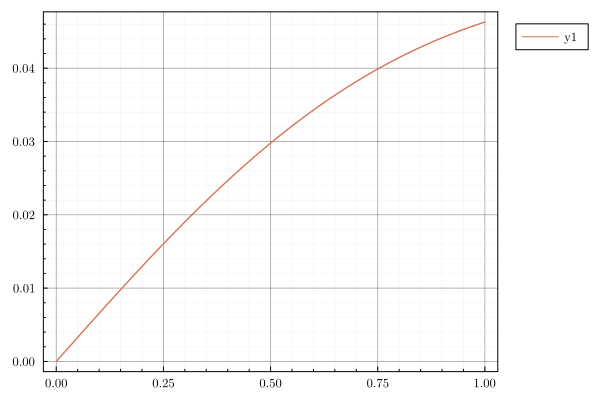

In [15]:
plot(0:0.02:1,imag.((x->complex(ψNN(x,0.0)...)).(0:0.02:1)))